# Modeling the Effect of Lasers on CO2 Concentration, Atmospheric Absorption, and Thermal Equilibrium Temperature of Mars

In [1]:
# Import Libraries
import pandas as pd
import math
import numpy as np
from typing import Callable
import functools
import bisect
from tqdm import tqdm
import matplotlib.pyplot as plt
from Unit0 import model_utils

In [2]:
# Constants
plancks_constant = 6.62607015e-34
speed_of_light = 299792458
boltzmann_constant = 1.380649e-23

energies = np.linspace(0, 1e25, 1000)
dry_ice_enthalpy_of_sublimation = 571e3 # J/kg

absorption_components = ["CO2"]
wavelengths = np.linspace(0.1e-6, 40e-6, 3991)
temperature_sun = 5772
steradian_sun_from_mars = 2.927e-5 # Solid angle that the sun takes up when viewed from Mars in steradians
radius_mars = 3.3895e6
gravitational_acceleration_mars = 3.72076
mass_atmosphere_mars = 2.4678e16
mass_atmosphere_earth = 5.15e18
air_molar_mass = 0.02896
co2_molar_mass = 0.04401
co2_concentration_earth = 421e-6
atmospheric_pressure_mars = 636
atmospheric_pressure_earth = 101325

## Laser and Amount of CO2 Sublimated

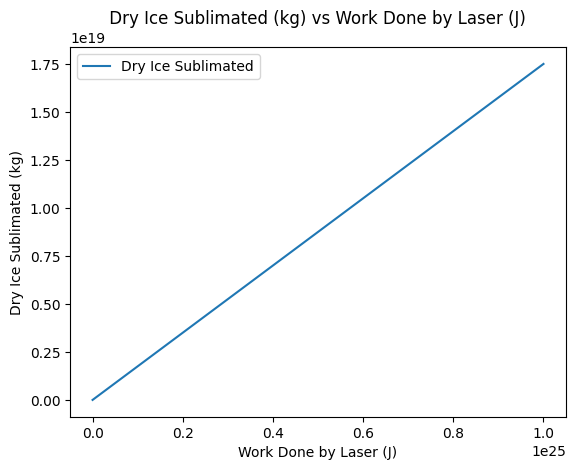

In [3]:
# Graph Dry Ice Sublimated vs Work Done
masses = energies / dry_ice_enthalpy_of_sublimation
model_utils.graph([(energies, masses, "Dry Ice Sublimated")], "Dry Ice Sublimated", "kg", "Work Done by Laser", "J", directory="Graphs/Dry_Ice_Sublimated")

In [4]:
# Calculate Relative CO2 Concentration of Mars
relative_co2_concentrations = (masses + mass_atmosphere_mars) / mass_atmosphere_mars

## Absorption Data for CO2

In [5]:
# Load Data
data1 = pd.read_csv("../Unit12/Data/Absorption 0.1-3 Microns.csv")
data2 = pd.read_csv("../Unit12/Data/Absorption 3-12 Microns.csv")
data3 = pd.read_csv("../Unit12/Data/Absorption 12-40 Microns.csv")

In [6]:
# Processes data into lists of tuples of wavelength and transmittance
def load_transmittance_for_component(data: pd.DataFrame, wavelength_key: str, component: str):
    return list(filter(lambda x: not math.isnan(x[0]) and not math.isnan(x[1]), zip(map(lambda x: x * 1e-6, data[wavelength_key]), data[f"{component} Transmittance"])))


transmittances = [load_transmittance_for_component(data1, f"{component} Wavelength (microns)", component) + load_transmittance_for_component(data2, "Wavelength (microns)", component) + load_transmittance_for_component(data3, "Wavelength (microns)", component) for component in absorption_components]

In [7]:
# Finds value in a less than or equal to x
def find_le[T, K](a: list[T], x: K, key: Callable[[T], K]) -> T:
    i = bisect.bisect(a, x, key=key)
    return a[i - 1 if i else 0]


# Finds value in a greater than or equal to x
def find_ge[T, K](a: list[T], x: K, key: Callable[[T], K]) -> T:
    i = bisect.bisect_left(a, x, key=key)
    return a[i if i < len(a) else i - 1]


# Interpolates value of x based on lower and upper bounds in a
def interpolate[K, V](a: list[tuple[K, V]], x: K) -> V:
    key: Callable[[tuple[K, V]], K] = lambda p: p[0]
    value: Callable[[tuple[K, V]], V] = lambda p: p[1]
    p0: tuple[K, V] = find_le(a, x, key)
    p1: tuple[K, V] = find_ge(a, x, key)
    x0: K = key(p0)
    x1: K = key(p1)
    y0: V = value(p0)
    if x0 == x1:
        return y0
    y1: V = value(p1)
    return y0 + (y1 - y0) / (x1 - x0) * (x - x0)

In [8]:
# Interpolate Transmittances
transmittances_interpolated = [[interpolate(transmittance, wavelength) for transmittance in transmittances] for wavelength in tqdm(wavelengths)]

100%|██████████| 3991/3991 [00:00<00:00, 397310.06it/s]


## Absorption Data for Different Concentrations of CO2

In [9]:
# Calculate Transmittances for Each CO2 Concentration
relative_transmittances_interpolated = [list(map(lambda x: [1 - np.clip((1 - x[0]) * relative_co2_concentration, 0, 1)], transmittances_interpolated)) for relative_co2_concentration in tqdm(relative_co2_concentrations)]

100%|██████████| 1000/1000 [00:10<00:00, 91.07it/s]


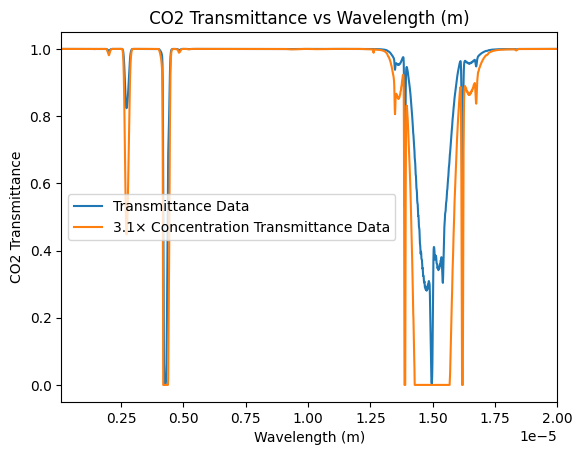

In [20]:
# Graph Transmittances
plt.xlim(1e-7, 2e-5)
model_utils.graph([(wavelengths, list(map(lambda x: x[0], transmittances_interpolated)), "Transmittance Data"), (wavelengths, list(map(lambda x: x[0], relative_transmittances_interpolated[3])), f"{relative_co2_concentrations[3]:.1f}× Concentration Transmittance Data")], "CO2 Transmittance", "", "Wavelength", "m", directory="Graphs/Transmittances")

## Solar Radiation on Mars

In [11]:
# Define Calculation Functions
def plancks_law(wavelength: float, temperature: float) -> float:
    return 2 * plancks_constant * speed_of_light ** 2 / wavelength ** 5 / math.expm1(plancks_constant * speed_of_light / wavelength / boltzmann_constant / temperature)


def spectral_radiance(wavelength: float, temperature: float, transmittances_for_wavelength: list[float]) -> float:
    return plancks_law(wavelength, temperature) * functools.reduce(lambda x, y: x * y, transmittances_for_wavelength)


def radiance_from_spectral(wavelengths: list[float], spectral_radiances: list[float]) -> float:
    delta_wavelength = wavelengths[1] - wavelengths[0]
    return functools.reduce(lambda x, y: x + y, map(lambda x: x * delta_wavelength, spectral_radiances))


def radiance(wavelengths: list[float], temperature: float, transmittances: list[list[float]]) -> float:
    return radiance_from_spectral(wavelengths, [spectral_radiance(wavelength, temperature, transmittances_for_wavelength) for wavelength, transmittances_for_wavelength in zip(wavelengths, transmittances)])

In [12]:
# Calculate Solar Spectral Radiance on Mars
spectral_radiance_sun_without_transmittances = [plancks_law(wavelength, temperature_sun) * steradian_sun_from_mars for wavelength in tqdm(wavelengths)]
spectral_radiance_sun = [spectral_radiance(wavelength, temperature_sun, transmittances_for_wavelength) * steradian_sun_from_mars for wavelength, transmittances_for_wavelength in zip(tqdm(wavelengths), transmittances_interpolated)]

100%|██████████| 3991/3991 [00:00<00:00, 856589.26it/s]


In [13]:
# Calculate Solar Radiance on Mars
radiance_sun_without_transmittances = radiance_from_spectral(wavelengths, spectral_radiance_sun_without_transmittances)
radiance_sun = radiance_from_spectral(wavelengths, spectral_radiance_sun)

print(f"Radiance of the Sun without Absorption: {radiance_sun_without_transmittances} W/m^2")
print(f"Radiance of the Sun with Absorption: {radiance_sun} W/m^2")

# Calculate Solar Power on Mars
power_sun_without_transmittances = radiance_sun_without_transmittances * math.pi * radius_mars ** 2
power_sun = radiance_sun * math.pi * radius_mars ** 2

print(f"Power of the Sun without Absorption: {power_sun_without_transmittances} W")
print(f"Power of the Sun with Absorption: {power_sun} W")

Radiance of the Sun without Absorption: 586.3873649517411 W/m^2
Radiance of the Sun with Absorption: 585.3080960200698 W/m^2
Power of the Sun without Absorption: 2.116438986849985e+16 W
Power of the Sun with Absorption: 2.1125435979299436e+16 W


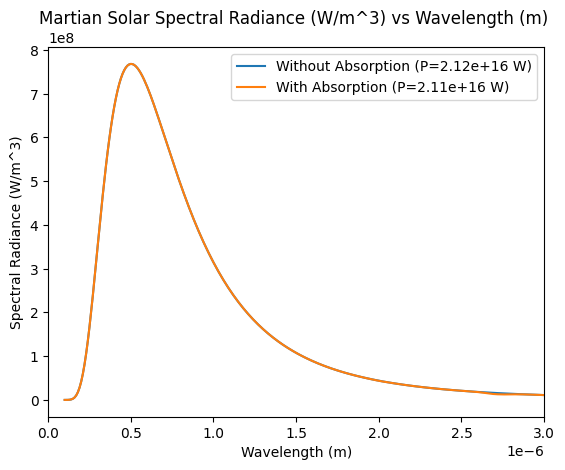

In [14]:
# Graph Solar Spectral Radiance
plt.xlim(0, 3e-6)
model_utils.graph([(wavelengths, spectral_radiance_sun_without_transmittances, f"Without Absorption (P={power_sun_without_transmittances:.2e} W)"), (wavelengths, spectral_radiance_sun, f"With Absorption (P={power_sun:.2e} W)")], "Spectral Radiance", "W/m^3", "Wavelength", "m", "Martian Solar", directory="Graphs/Spectral_Radiance_Sun")

## Radiance and Equilibrium Temperature of Mars

In [15]:
# Binary Search for the Thermal Equilibrium Temperature of Mars
def binary_search(value: Callable[[float], float], target: float, left: float, right: float) -> float:
    while right - left > 1e-2:
        mid = (left + right) / 2
        power = value(mid)
        if power < target:
            left = mid
        else:
            right = mid
    return (left + right) / 2

# Fit Mars Power for Each CO2 Concentration
temperatures_mars = [binary_search(lambda temperature: radiance(wavelengths, temperature, transmittances_interpolated) * 4 * math.pi ** 2 * radius_mars ** 2, power_sun, 200, 500) for transmittances_interpolated in tqdm(relative_transmittances_interpolated)]

100%|██████████| 1000/1000 [00:40<00:00, 24.52it/s]


In [16]:
# Calculate Martian Spectral Radiance
spectral_radiance_mars_without_transmittances = [plancks_law(wavelength, temperatures_mars[0]) * 4 * math.pi for wavelength in tqdm(wavelengths)]
spectral_radiance_mars = [spectral_radiance(wavelength, temperatures_mars[0], transmittances_for_wavelength) * 4 * math.pi for wavelength, transmittances_for_wavelength in zip(tqdm(wavelengths), relative_transmittances_interpolated[0])]
spectral_radiance_mars_3 = [spectral_radiance(wavelength, temperatures_mars[3], transmittances_for_wavelength) * 4 * math.pi for wavelength, transmittances_for_wavelength in zip(tqdm(wavelengths), relative_transmittances_interpolated[3])]

100%|██████████| 3991/3991 [00:00<00:00, 1156839.48it/s]


In [17]:
# Calculate Martian Radiance
radiance_mars_without_transmittances = radiance_from_spectral(wavelengths, spectral_radiance_mars_without_transmittances)
radiance_mars = radiance_from_spectral(wavelengths, spectral_radiance_mars)
radiance_mars_3 = radiance_from_spectral(wavelengths, spectral_radiance_mars_3)

print(f"Radiance of Mars without Absorption: {radiance_mars_without_transmittances} W/m^2")
print(f"Radiance of Mars with Absorption: {radiance_mars} W/m^2")
print(f"Radiance of Mars with Absorption ({relative_co2_concentrations[3]:.1f}× CO2 Concentration): {radiance_mars_3} W/m^2")

# Calculate Martian Power
power_mars_without_transmittances = radiance_mars_without_transmittances * math.pi * radius_mars ** 2
power_mars = radiance_mars * math.pi * radius_mars ** 2
power_mars_3 = radiance_mars_3 * math.pi * radius_mars ** 2

print(f"Power of Mars without Absorption: {power_mars_without_transmittances} W")
print(f"Power of Mars with Absorption: {power_mars} W")
print(f"Power of Mars with Absorption ({relative_co2_concentrations[3]:.1f}× CO2 Concentration): {power_mars_3} W")

Radiance of Mars without Absorption: 621.7178940049149 W/m^2
Radiance of Mars with Absorption: 585.3563233287672 W/m^2
Radiance of Mars with Absorption (3.1× CO2 Concentration): 585.3152550150993 W/m^2
Power of Mars without Absorption: 2.2439569273505052e+16 W
Power of Mars with Absorption: 2.1127176640208228e+16 W
Power of Mars with Absorption (3.1× CO2 Concentration): 2.1125694367816868e+16 W


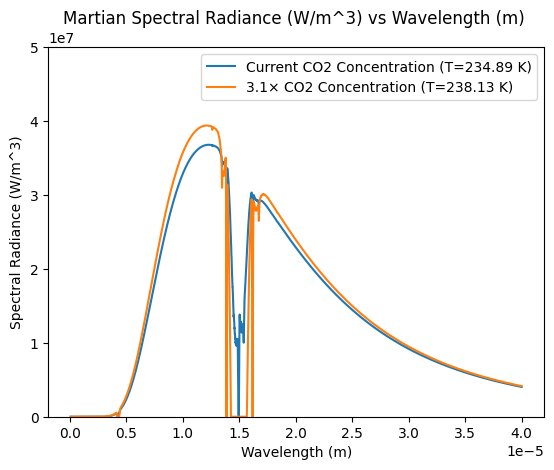

In [18]:
# Graph Mars Spectral Radiance
plt.ylim(0, 5e7)
model_utils.graph([(wavelengths, spectral_radiance_mars, f"Current CO2 Concentration (T={temperatures_mars[0]:.2f} K)"), (wavelengths, spectral_radiance_mars_3, f"{relative_co2_concentrations[3]:.1f}× CO2 Concentration (T={temperatures_mars[3]:.2f} K)")], "Spectral Radiance", "W/m^3", "Wavelength", "m", "Martian", directory="Graphs/Spectral_Radiance_Mars")

## Thermal Equilibrium Temperature of Mars

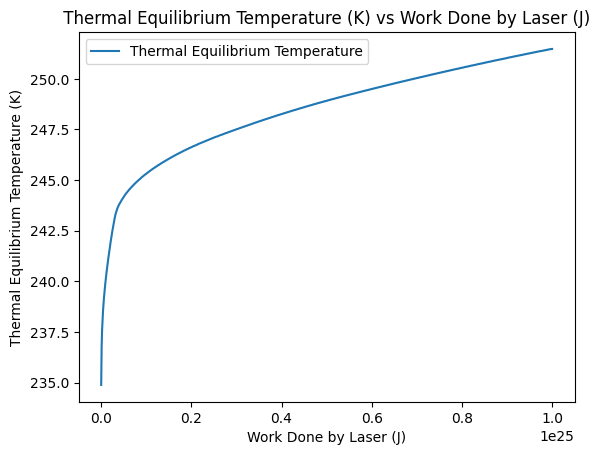

In [19]:
# Graph Mars Thermal Equilibrium Temperature vs Work Done
model_utils.graph([(energies, temperatures_mars, "Thermal Equilibrium Temperature")], "Thermal Equilibrium Temperature", "K", "Work Done by Laser", "J", directory="Graphs/Thermal_Equilibrium_Temperature")